# Project: Intelligent-Concrete-Strength-Prediction-System

In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is NOT available. Running on CPU.")

GPU is available!
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU
Current Device Index: 0
Total GPU Memory (MB): 8187.5


## 1. Data Preparation

### i. Load the Dataset

We are using the **UCI Concrete Compressive Strength Dataset** which contains 1030 samples and 8 features.  
The file is in `.xls` format, so we use `pandas.read_excel()` to load it.


In [820]:
import pandas as pd

df = pd.read_excel(r"concrete+compressive+strength\Concrete_Data.xls")

# Quick view of the data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [821]:
df 

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


### ii. Preprocessing Pipeline

Data Cleaning:

    Handling missing values using median imputation
    Scaling features using RobustScaler
    Removing outliers using IQR method


Feature Engineering:

    Creating three new features:
    - Interaction term: `Cement * Age`
    - Polynomial feature: `Cement²`
    - Polynomial feature: `Age²`

    Generating polynomial features

    Normalizing numerical features

In [822]:
df.isna().sum()

Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64

In [823]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# 1. Handle missing values
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 2. Remove outliers using IQR
Q1 = df_imputed.quantile(0.25)
Q3 = df_imputed.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df_imputed[~((df_imputed < (Q1 - 1.5 * IQR)) | (df_imputed > (Q3 + 1.5 * IQR))).any(axis=1)]

# 3. Scale using RobustScaler
df_normalized = RobustScaler()
df_scaled = pd.DataFrame(df_normalized.fit_transform(df_no_outliers), columns=df_no_outliers.columns)
df_scaled

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,1.793143,-0.137931,0.000000,-0.804428,-0.436893,0.878788,-1.280788,0.000000,1.294567
1,0.066179,0.648276,0.000000,1.630996,-0.679612,-0.363636,-1.354680,2.952381,0.619431
2,0.784697,0.517241,0.000000,1.630996,-0.679612,-0.363636,-2.290640,0.000000,0.138574
3,0.066179,0.648276,0.000000,1.630996,-0.679612,-0.363636,-1.354680,0.000000,0.566013
4,1.383461,-0.137931,0.000000,1.630996,-0.679612,-0.363636,-2.290640,0.000000,0.267717
...,...,...,...,...,...,...,...,...,...
936,0.131728,0.662069,0.763249,-0.154982,0.184466,-0.988889,-0.144089,0.000000,0.494674
937,0.420396,-0.137931,0.977094,0.450185,0.330097,-1.516162,0.411330,0.000000,-0.100852
938,-0.674398,0.823448,0.917927,0.328413,-0.087379,-0.763636,0.000000,0.000000,-0.440848
939,-0.607589,1.149655,0.000000,-0.302583,0.417476,0.218182,0.109606,0.000000,-0.028636


In [824]:
df_scaled = df_scaled.rename(columns={
    'Cement (component 1)(kg in a m^3 mixture)': 'Cement',
    'Age (day)': 'Age'
})

df_scaled['cement_age_interaction'] = df_scaled['Cement'] * df_scaled['Age']
df_scaled['Cement_squared'] = df_scaled['Cement'] ** 2
df_scaled['Age_squared'] = df_scaled['Age'] ** 2




Feature–Target Correlation:

Concrete compressive strength(MPa, megapascals)          1.000000
Age                                                      0.517507
Cement                                                   0.476762
Superplasticizer (component 5)(kg in a m^3 mixture)      0.402735
Cement_squared                                           0.290788
Age_squared                                              0.271608
cement_age_interaction                                   0.163093
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0.141413
Fly Ash (component 3)(kg in a m^3 mixture)              -0.054793
Fine Aggregate (component 7)(kg in a m^3 mixture)       -0.156873
Coarse Aggregate  (component 6)(kg in a m^3 mixture)    -0.168203
Water  (component 4)(kg in a m^3 mixture)               -0.369213
Name: Concrete compressive strength(MPa, megapascals) , dtype: float64


C:\Users\ahsan\AppData\Local\Temp\ipykernel_38672\2217820092.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation.values, y=correlation.index, palette='viridis')


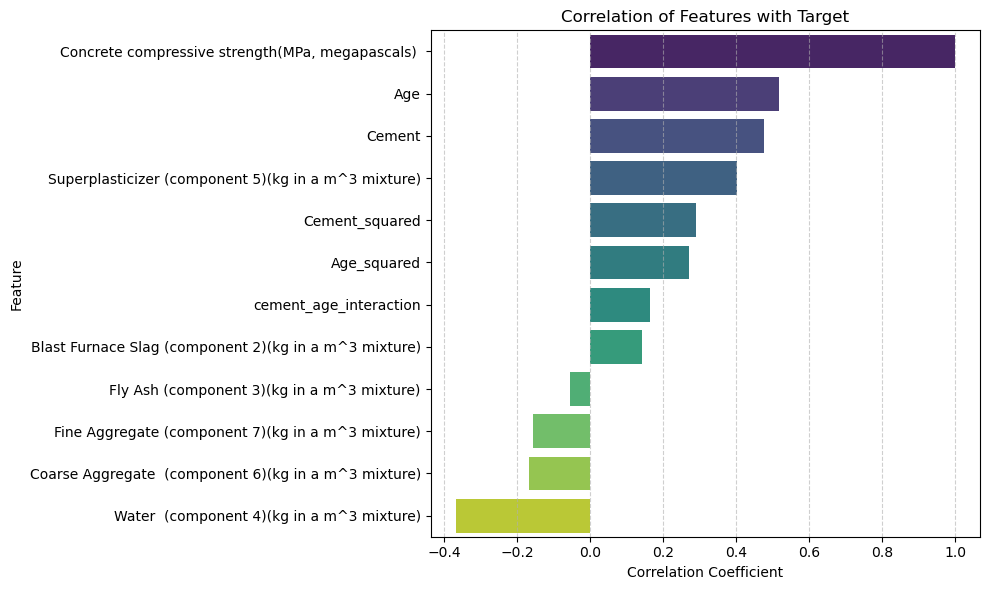

In [825]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure your final DataFrame is named `df_scaled`
# and the target column is named like below (adjust if needed)
target_column = 'Concrete compressive strength(MPa, megapascals) '

# Compute correlation of all features with the target
correlation = df_scaled.corr()[target_column].sort_values(ascending=False)

# Print correlation values
print("Feature–Target Correlation:\n")
print(correlation)

# Optional: Plot as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette='viridis')
plt.title("Correlation of Features with Target")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()



### iii. Dataset Split

Splitting the dataset into:
- Training Set: 70%
- Validation Set: 15%
- Test Set: 15%


In [826]:
from sklearn.model_selection import train_test_split

target_column = 'Concrete compressive strength(MPa, megapascals) '
X = df_scaled.drop(columns=[target_column])
y = df_scaled[target_column]

# 70% training, 30% temp (to be split into val/test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# 15% val, 15% test from the remaining 30%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Show shapes
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (658, 11)
Validation set: (141, 11)
Test set: (142, 11)


## 2. Model Development

### Neural Network Model

In [827]:
import torch
import torch.nn as nn

class ConcreteStrengthPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.1),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)


### Feature Importance Analyzer

We compute feature importance by backpropagating gradients and taking the absolute gradient of input features.  
This approach assumes differentiability and is useful for understanding sensitivity of outputs to inputs.


In [828]:
class FeatureImportanceAnalyzer:
    def __init__(self, model):
        self.model = model

    def analyze(self, x):
        x.requires_grad_(True)
        y = self.model(x)
        y.backward(torch.ones_like(y)) 
        importance = torch.abs(x.grad)
        return importance


### 3. Training Protocol

We define our loss, optimizer, and training configuration:

- **Loss Function**: MSE Loss with L2 regularization
- **Optimizer**: Adam with weight decay
- **Scheduler**: ReduceLROnPlateau
- **Training Hyperparameters**:
  - Batch size: 32
  - Learning rate: 0.001
  - Weight decay: 0.01
  - Early stopping: 10 epochs
  - Gradient clipping: 1.0

In [829]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Model instantiation
input_size = X_train.shape[1]
model = ConcreteStrengthPredictor(input_size)

# Loss with MSE
criterion = nn.MSELoss()

# Optimizer with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


c:\Users\ahsan\anaconda3\envs\aien\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


###  PyTorch Dataset & DataLoader

We wrap our training, validation, and test sets using PyTorch’s `TensorDataset` and `DataLoader` for efficient mini-batch processing.


In [830]:
from torch.utils.data import TensorDataset, DataLoader

# Convert to float tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Wrap into DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


### Model Training Loop

We train the model using mini-batches, apply gradient clipping, and monitor validation loss for early stopping.  
We also use ReduceLROnPlateau scheduler to reduce learning rate when validation stagnates.


In [ ]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import os 
print(f"Val preds: {val_preds[:5].squeeze().cpu().numpy()}")
print(f"Val loss: {val_loss}")
print(f"[DEBUG] Best Val Loss: {best_val_loss}, Current: {val_loss}")
print("Any NaNs in training inputs:", torch.isnan(X_train_tensor).any().item())
print("Any NaNs in training targets:", torch.isnan(y_train_tensor).any().item())
print("Any Infs in training inputs:", torch.isinf(X_train_tensor).any().item())
# Reinitialize model
model = ConcreteStrengthPredictor(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

best_val_loss = np.inf
patience = 10
patience_counter = 0
num_epochs = 100

train_losses, val_losses = [], []

log_dir = "runs/concrete_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=log_dir)

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses)

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor.to(device))
        val_loss = criterion(val_preds, y_val_tensor.to(device)).item()

    # Record losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Scheduler step
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:03d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)

writer.close()
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
    print("Best model loaded from saved checkpoint.")
else:
    print("best_model.pth not found — training might not have saved it.")


Val preds: [nan nan nan nan nan]
Val loss: nan
[DEBUG] Best Val Loss: inf, Current: nan
Any NaNs in training inputs: False
Any NaNs in training targets: False
Any Infs in training inputs: False
Epoch 001: Train Loss = 0.7024, Val Loss = 0.5346
Epoch 002: Train Loss = 0.4862, Val Loss = 0.4182
Epoch 003: Train Loss = 0.4207, Val Loss = 0.3345
Epoch 004: Train Loss = 0.3317, Val Loss = 0.2789
Epoch 005: Train Loss = 0.3097, Val Loss = 0.2307
Epoch 006: Train Loss = 0.2812, Val Loss = 0.2071
Epoch 007: Train Loss = 0.2184, Val Loss = 0.1840
Epoch 008: Train Loss = 0.2399, Val Loss = 0.1725
Epoch 009: Train Loss = 0.1929, Val Loss = 0.1609
Epoch 010: Train Loss = 0.2164, Val Loss = 0.1551
Epoch 011: Train Loss = 0.1761, Val Loss = 0.1440
Epoch 012: Train Loss = 0.1723, Val Loss = 0.1374
Epoch 013: Train Loss = 0.1678, Val Loss = 0.1339
Epoch 014: Train Loss = 0.1748, Val Loss = 0.1295
Epoch 015: Train Loss = 0.1727, Val Loss = 0.1274
Epoch 016: Train Loss = 0.1864, Val Loss = 0.1341
Epoch 

C:\Users\ahsan\AppData\Local\Temp\ipykernel_38672\2758551468.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loca

In [832]:
from torch.utils.tensorboard import SummaryWriter
import datetime

# Setup TensorBoard writer
log_dir = "runs/concrete_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir=log_dir)


### 4. Model Evaluation

We evaluate the model using:
- **Mean Absolute Error (MAE)**
- **Root Mean Squared Error (RMSE)**
- **R² Score**

**Performance Targets**:
- MAE ≤ 5 MPa
- RMSE ≤ 8 MPa
- R² ≥ 0.92

In [833]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the best model and prepare it for inference
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))
model.eval()

# Move data to device
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

with torch.no_grad():
    # Validation
    y_val_pred = model(X_val_tensor).cpu().numpy()
    y_val_true = y_val_tensor.cpu().numpy()

    mae_val = mean_absolute_error(y_val_true, y_val_pred)
    mse_val = mean_squared_error(y_val_true, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val_true, y_val_pred)

    # Test
    y_test_pred = model(X_test_tensor).cpu().numpy()
    y_test_true = y_test_tensor.cpu().numpy()

    mae_test = mean_absolute_error(y_test_true, y_test_pred)
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test_true, y_test_pred)

# Print both sets
print("Validation Set Evaluation")
print(f"MAE:  {mae_val:.2f} MPa")
print(f"RMSE: {rmse_val:.2f} MPa")
print(f"R²:   {r2_val:.4f}")

print("\n Test Set Evaluation")
print(f"MAE:  {mae_test:.2f} MPa")
print(f"RMSE: {rmse_test:.2f} MPa")
print(f"R²:   {r2_test:.4f}")

# Target check (for test set)
print("\n Target Check (Test Set):")
print("MAE ≤ 5:", mae_test <= 5)
print("RMSE ≤ 8:", rmse_test <= 8)
print("R² ≥ 0.92:", r2_test >= 0.92)


Validation Set Evaluation
MAE:  0.23 MPa
RMSE: 0.30 MPa
R²:   0.8375

 Test Set Evaluation
MAE:  0.22 MPa
RMSE: 0.29 MPa
R²:   0.8518

 Target Check (Test Set):
MAE ≤ 5: True
RMSE ≤ 8: True
R² ≥ 0.92: False


C:\Users\ahsan\AppData\Local\Temp\ipykernel_38672\3933186767.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

###  Training & Validation Loss Curve
Visualizing training and validation loss across epochs helps understand convergence and overfitting.


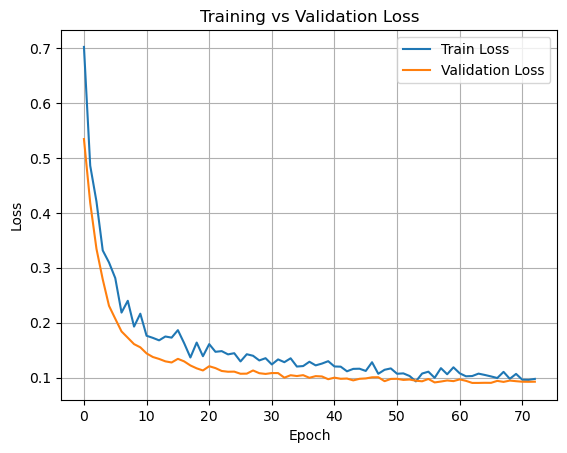

In [834]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Predicted vs Actual (Test Set)

This plot helps visually assess how well the model predicts actual concrete compressive strength.


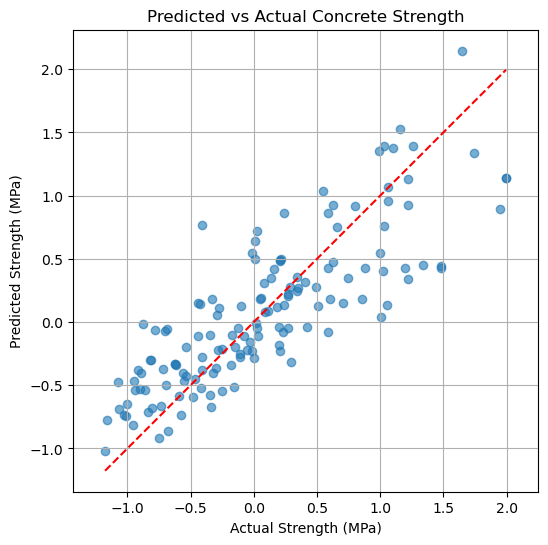

In [835]:
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
plt.xlabel("Actual Strength (MPa)")
plt.ylabel("Predicted Strength (MPa)")
plt.title("Predicted vs Actual Concrete Strength")
plt.grid(True)
plt.axis("equal")
plt.show()


### 16. Feature Importance via Gradient Analysis

We analyze feature sensitivity using backpropagated gradients on the trained model.


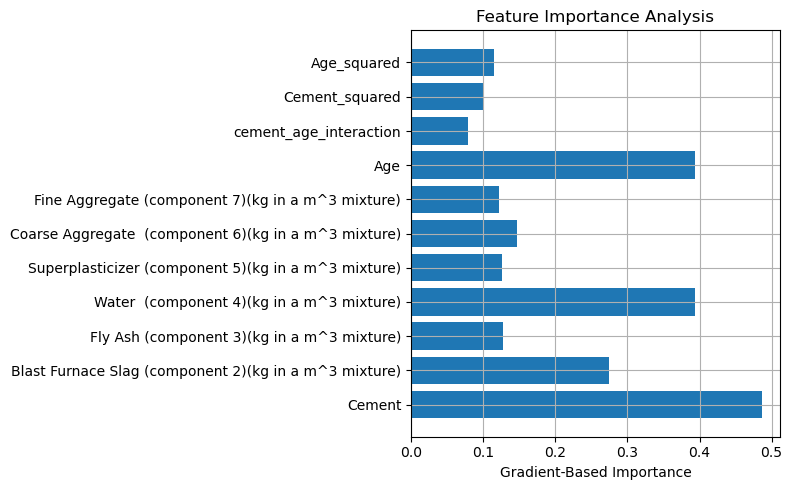

In [836]:
analyzer = FeatureImportanceAnalyzer(model)
sample_x = X_test_tensor.clone().detach().requires_grad_(True).to(device)
importances = analyzer.analyze(sample_x)
mean_importance = importances.mean(dim=0).cpu().numpy()

# Plot
import matplotlib.pyplot as plt

feature_names = X_test.columns
plt.figure(figsize=(8, 5))
plt.barh(feature_names, mean_importance)
plt.xlabel("Gradient-Based Importance")
plt.title("Feature Importance Analysis")
plt.grid(True)
plt.tight_layout()
plt.show()
